# VGG-16 converts a query image to query_features
## Input
* `data/images/train`: Recipe images, train

In [1]:
import torch.nn as nn
import torchvision.models as models

# Get the pre-trained VGG16
feat_extractor = models.vgg16(pretrained=True)
# Remove the last FC layer to get 4096 internal features instead of classification results
# See also: https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html#vgg16
feat_extractor.classifier = nn.Sequential(*list(feat_extractor.classifier.children())[:-1])
feat_extractor.eval();

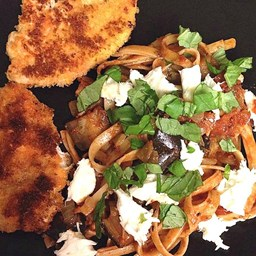

In [2]:
from IPython.display import Image
img_path = 'data/images/train/0/0/0/0/00002338b4.jpg'
Image(filename=img_path)

In [3]:
from PIL import Image
import torchvision.transforms as transforms

def get_image_for_vgg(path):
    img = Image.open(path).convert('RGB')
    
    # VGG-16 expects a 224x224 image
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    return transform(img)

x = get_image_for_vgg(img_path).unsqueeze(0) # the model expects a batch of images, thus unsqueeze it here
query_features = feat_extractor.forward(x)
print(query_features.shape)

torch.Size([1, 4096])


/home/k0kubun/miniconda3/envs/food-recipe-cnn/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-qytotgph/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


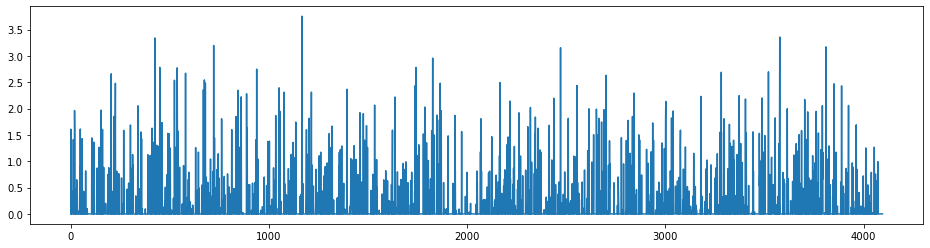

In [4]:
import matplotlib.pyplot
%matplotlib inline

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(query_features[0].detach().numpy())
matplotlib.pyplot.show()

# Dimensionality reduction by sklern's IncrementalPCA 
## Input
* `data/images/train`: Recipe images, train

In [5]:
import torch

# This should be replaced by a serious DataLoader later
img_paths = [
    'data/images/train/0/0/0/0/00002338b4.jpg',
    'data/images/train/0/0/0/0/00002978e7.jpg',
    'data/images/train/0/0/0/0/00004fa620.jpg',
    'data/images/train/0/0/0/0/000063ddf9.jpg',
    'data/images/train/0/0/0/0/000077a11c.jpg',
    'data/images/train/0/0/0/0/00009974ff.jpg',
    'data/images/train/0/0/0/0/0000dfbc52.jpg',
]

# Generate features for the small dataset
img_tensors = torch.cat([get_image_for_vgg(path).unsqueeze(0) for path in img_paths])
img_features = feat_extractor.forward(img_tensors).detach().numpy()
img_features.shape

(7, 4096)

In [6]:
from sklearn.decomposition import IncrementalPCA

# We actually want to use n_components=512, but it must be smaller than batch_size. So using 5 in this PoC.
ipca = IncrementalPCA(n_components=5, batch_size=7)
ipca.partial_fit(img_features)

# We should dump ipca using pickle here.

IncrementalPCA(batch_size=7, n_components=5)

In [7]:
features_ipca = ipca.transform(img_features)
features_ipca.shape

(7, 5)

# NMSLIB finds Approximate Nearest Neighbors

In [14]:
import nmslib

def create_ann_index(features_ipca):
    # Index parameters
    M = 15
    efC = 100
    num_threads = 4
    index_time_params = {'M': M, 'indexThreadQty': num_threads, 'efConstruction': efC, 'post': 0}
    space_name = 'l2'
    efS = 100
    query_time_params = {'efSearch': efS}
    
    # Intitialize the library, specify the space, the type of the vector and add data points 
    index_ann = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR)
    index_ann.addDataPointBatch(features_ipca)
    index_ann.createIndex(index_time_params, print_progress=True)
    
    # Setting query-time parameters and querying
    index_ann.setQueryTimeParams(query_time_params)
    return index_ann
    
index_ann = create_ann_index(features_ipca)

In [16]:
# Return the 5-nearest neighbors
idx_closest, _distances = index_ann.knnQuery(features_ipca, k = 5)

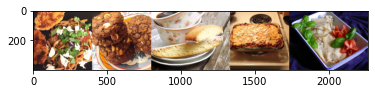

In [22]:
import numpy as np
from matplotlib.pyplot import imshow

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = Image.open(img_paths[idx]).convert('RGB')
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

results_image = get_concatenated_images(idx_closest, 400)
imshow(results_image);